# Лабораторная работа 2
## Линейная нейронная сеть

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LinearModel:

    def __init__(self, lr: float, in_size: int, epochs=50):
        self.trained = False
        self.epochs = epochs
        self.lr = lr
        self.w = np.random.randn(in_size + 1) / np.sqrt(in_size)

    def fit(self, features: np.ndarray, targets: np.ndarray):
        features = np.c_[features, np.ones(features.shape[0])]
        for epoch in range(self.epochs):
            predicts = np.dot(features, self.w.T)
            errors = targets - predicts
            for error, feature in zip(errors, features):
                self.w += self.lr * error * feature

    def predict(self, window):
        v = np.append(window, 1)
        return np.dot(v, self.w)

    def get_weights(self):
        return self.w

In [3]:
def convert_to_features_and_targets(x: np.ndarray, d: int) -> (np.ndarray, np.ndarray):
    n = x.shape[0]
    features = np.zeros((n-d, d))
    targets = np.zeros(n-d)
    for i in range(d-1, n-1):
        features[i-d+1] = x[i-d+1:i+1]
        targets[i-d+1] = x[i+1]
    return features, targets

class TimeSeriesApproximator:

    def __init__(self, model: LinearModel, deep: int):
        self.d = deep
        self.model = model

    def approximate_time_series(self, values: np.ndarray) -> np.ndarray:
        features, targets = convert_to_features_and_targets(values, self.d)
        return self.__approximate(features, targets)


    def approximate_and_extend(self, values: np.ndarray, series_size: int):
        features, targets = convert_to_features_and_targets(values, self.d)
        n = values.shape[0]
        predicts = np.zeros(n + series_size)
        predicts[:n] = self.__approximate(features, targets)
        features = np.concatenate((features, np.zeros((series_size, self.d))))
        for i in range(series_size):
            predicts[n+i] = self.model.predict(features[n-self.d+i-1])
            features[n-self.d+i] = np.concatenate((features[n-self.d+i-1][-self.d:-1], [predicts[n+i]]))
        return predicts

    def __approximate(self, features: np.ndarray, targets: np.ndarray):
        self.model.fit(features, targets)
        predicts = np.zeros(targets.shape[0] + self.d)
        predicts[:self.d] = features[0]
        for i in range(self.d, predicts.shape[0]):
            predicts[i] = self.model.predict(features[i-self.d])
        return predicts

def mse(values, approx_values):
    return np.sum((values - approx_values) ** 2) / values.shape[0]

In [4]:
def draw_chart(times: np.ndarray, time_series: np.ndarray, approx_time_series: np.ndarray):
    plt.figure(figsize=(10, 7))
    plt.plot(times, time_series, label='Original time series')
    plt.plot(times, approx_time_series, label='Approximation time series')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.figure(figsize=(6, 4))
    plt.plot(times, time_series - approx_time_series, label='Error')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

### Часть 1

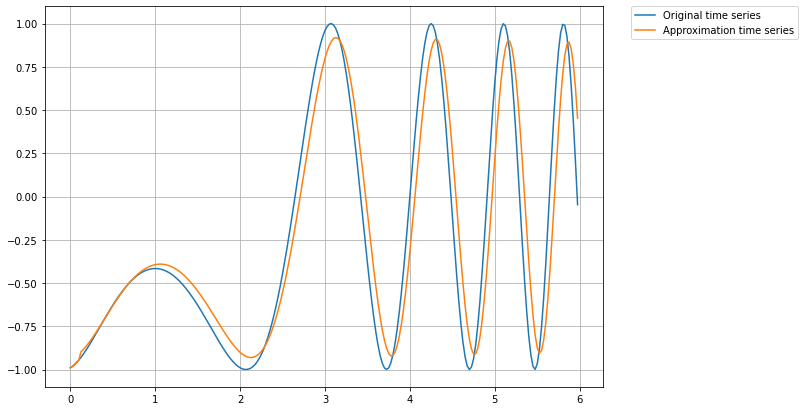

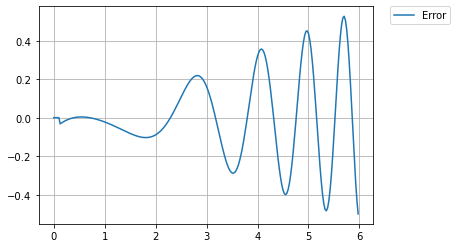

mse 0.04435735351807845
sqrt(mse) 0.21061185512235167


In [5]:
def approximation_example():
    signal = lambda t: np.cos(t**2 - 2*t + 3)
    times = np.arange(0, 6, 0.025)
    time_series = signal(times)
    linear_model = LinearModel(lr=0.001, in_size=5, epochs=50)
    approximator = TimeSeriesApproximator(model=linear_model, deep=5)
    approx_time_series = approximator.approximate_time_series(time_series)
    draw_chart(times, time_series, approx_time_series)

    print('mse', mse(time_series, approx_time_series))
    print('sqrt(mse)', np.sqrt(mse(time_series, approx_time_series)))


approximation_example()

### Часть 2

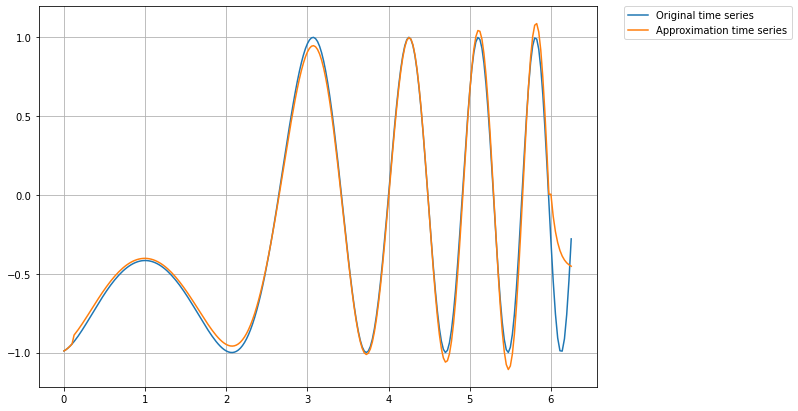

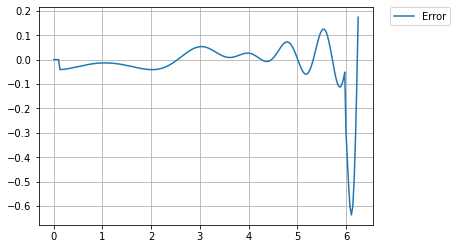

mse 0.009893111721878003
sqrt(mse) 0.0994641227874554


In [6]:
def approximation_example():
    signal = lambda t: np.cos(t**2 - 2*t + 3)
    times = np.arange(0, 6, 0.025)
    time_series = signal(times)
    linear_model = LinearModel(lr=0.001, in_size=5, epochs=600)
    approximator = TimeSeriesApproximator(model=linear_model, deep=5)
    approx_time_series = approximator.approximate_and_extend(time_series, 10)
    times = np.concatenate((times, np.linspace(6, 6.25, 10)))
    time_series = signal(times)
    draw_chart(times, time_series, approx_time_series)

    print('mse', mse(time_series, approx_time_series))
    print('sqrt(mse)', np.sqrt(mse(time_series, approx_time_series)))


approximation_example()

### Часть 3

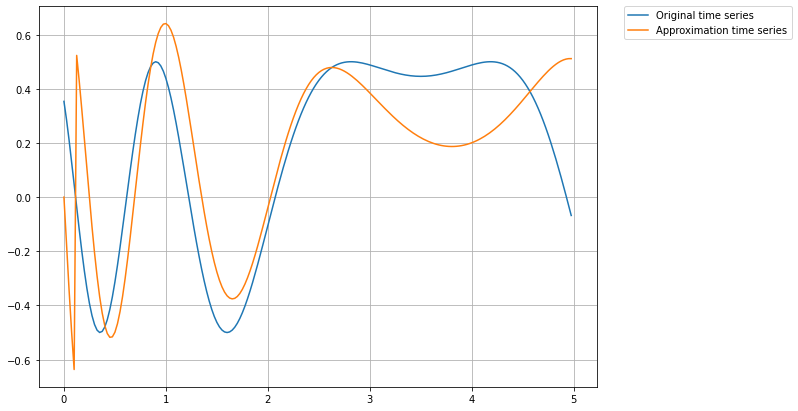

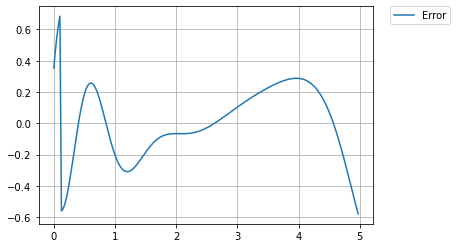

mse 0.05323092928153779
sqrt(mse) 0.2307182898721681


In [7]:
def approximation_example():
    d = 5
    signal = lambda t: np.sin(t**2 - 7*t)
    main_solve = lambda t: 1/2 * np.sin(t**2 - 7*t + np.pi/4)
    times = np.arange(0, 5, 0.025)
    time_series = signal(times)
    targets = main_solve(times)

    features, _ = convert_to_features_and_targets(time_series, d)
    linear_model = LinearModel(lr=0.001, in_size=d, epochs=600)
    linear_model.fit(features, targets[:len(targets)-d])
    predicts = np.zeros(targets.shape[0])
    predicts[:d] = features[0]
    for i in range(d, predicts.shape[0]):
        predicts[i] = linear_model.predict(features[i-d])
    draw_chart(times, targets, predicts)

    print('mse', mse(targets, predicts))
    print('sqrt(mse)', np.sqrt(mse(targets, predicts)))


approximation_example()